In [ ]:
import numpy as np
import pickle
import time
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Attention
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score, recall_score, precision_score, accuracy_score
from keras import layers, models
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import KFold
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Dropout, Attention, Reshape
from tensorflow.keras.optimizers import Adam

# Loading data
with open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/ccl_complete_data_28CCL_1298DepOI_36344samples_demo.pickle', 'rb') as f:
    data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)

premodel_mut = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_mut_100_50_25_demo.pickle', 'rb'))
premodel_exp = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_exp_100_50_25_demo.pickle', 'rb'))
premodel_cna = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_cna_100_50_25_demo.pickle', 'rb'))
premodel_meth = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/results/premodel_tcga_meth_100_50_25_demo.pickle', 'rb'))

print("\n\nDatasets successfully loaded.")

# model parameters
num_DepOI = 1298
num_ccl = int(data_mut.shape[0] / num_DepOI)

# Implementing K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

def build_model(hp):
    activation_func = 'relu'
    activation_func2 = 'linear'
    init = 'he_uniform'

    #  subnetworks
    input_mut = Input(shape=(premodel_mut[0][0].shape[0],))
    x = Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(input_mut)
    x = Dropout(hp.Float('dropout_mut_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(hp.Float('dropout_mut_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(25, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    model_mut = models.Model(input_mut, x)

    input_exp = Input(shape=(premodel_exp[0][0].shape[0],))
    x = Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(input_exp)
    x = Dropout(hp.Float('dropout_exp_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(hp.Float('dropout_exp_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(25, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    model_exp = models.Model(input_exp, x)

    input_cna = Input(shape=(premodel_cna[0][0].shape[0],))
    x = Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(input_cna)
    x = Dropout(hp.Float('dropout_cna_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(hp.Float('dropout_cna_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(25, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    model_cna = models.Model(input_cna, x)

    input_meth = Input(shape=(premodel_meth[0][0].shape[0],))
    x = Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(input_meth)
    x = Dropout(hp.Float('dropout_meth_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(hp.Float('dropout_meth_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(25, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    model_meth = models.Model(input_meth, x)

    input_gene = Input(shape=(data_fprint.shape[1],))
    x = Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(input_gene)
    x = Dropout(hp.Float('dropout_gene_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(hp.Float('dropout_gene_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(25, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    model_gene = models.Model(input_gene, x)

    # Merging subnetworks
    merged = layers.concatenate([model_mut.output, model_exp.output, model_cna.output, model_meth.output, model_gene.output])

    reshaped_merged = Reshape((-1, 25))(merged) 

    # Adding attention layer
    attention = Attention()([reshaped_merged, reshaped_merged])

    flattened_attention = layers.Flatten()(attention)

    x = Dense(hp.Int('dense_layer_dim_1', min_value=50, max_value=200, step=50), activation=activation_func, kernel_initializer=init, trainable=True)(flattened_attention)
    x = Dropout(hp.Float('dropout_merged_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int('dense_layer_dim_2', min_value=50, max_value=200, step=50), activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = Dropout(hp.Float('dropout_merged_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = Dense(1, activation=activation_func2, kernel_initializer=init, trainable=True)(x)

    model_final = models.Model(inputs=[model_mut.input, model_exp.input, model_cna.input, model_meth.input, model_gene.input], outputs=output)

    model_final.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='mse'
    )

    return model_final



Datasets successfully loaded.


In [ ]:
import keras_tuner as kt
import tensorflow as tf
from sklearn.model_selection import KFold
import pickle

Trial 5 Complete [00h 03m 03s]
val_loss: 0.18473628908395767

Best val_loss So Far: 0.048637259751558304
Total elapsed time: 00h 15m 46s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Validation metrics for current fold:
MSE: 0.0478
RMSE: 0.2186
R-squared (R2): 0.7414
MAE: 0.1624


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Validation metrics for current fold:
MSE: 0.0473
RMSE: 0.2175
R-squared (R2): 0.7467
MAE: 0.1565


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Validation metrics for current fold:
MSE: 0.0455
RMSE: 0.2133
R-squared (R2): 0.7580
MAE: 0.1558


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Validation metrics for current fold:
MSE: 0.0445
RMSE: 0.2108
R-squared (R2): 0.7637
MAE: 0.1559


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Validation metrics for current fold:
MSE: 0.0476
RMSE: 0.2181
R-squared (R2): 0.7513
MAE: 0.1585

Average Validation Metrics over 5 folds:
Average MSE: 0.0465
Average RMSE: 0.2157
Average R-squared (R2): 0.7522
Average MAE: 0.1578
Epoch 1/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 26.3831 - val_loss: 0.2251
Epoch 2/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2256 - val_loss: 0.1975
Epoch 3/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1972 - val_loss: 0.1901
Epoch 4/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1831 - val_loss: 0.1109
Epoch 5/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1144 - val_loss: 0.0689
Epoch 6/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0744 - val_loss: 0.0592
Epoch 7/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0637 - val_loss: 0.0598
Epoch 8/50
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0600 - val_loss: 0.0536
Epoch 9/50
1818/1818 

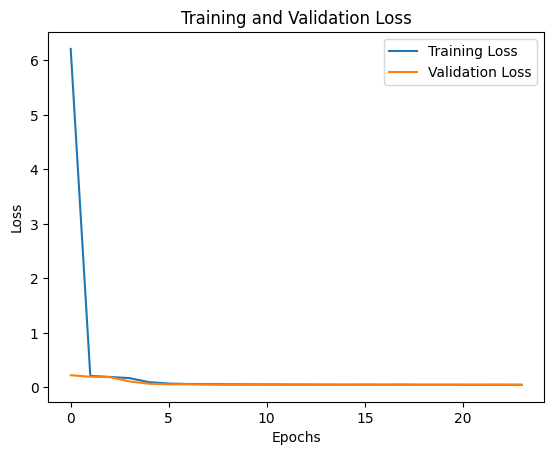


Binary Classification Metrics:
F1 Score: 0.0000
Recall (Sensitivity): 0.0000
Precision: 0.0000
Accuracy: 0.8000

Final training loss: 0.0492
Final validation loss: 0.0492


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Defining early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  
    executions_per_trial=2, 
    directory='my_dir',
    project_name='deepdep_hyperparameter_tuning'
)

# K-Fold Cross-Validation
val_scores = []
for train_index, val_index in kf.split(data_mut):
    id_train, id_val = train_index, val_index

    tuner.search(
        [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
        data_dep[id_train],
        validation_data=([data_mut[id_val], data_exp[id_val], data_cna[id_val], data_meth[id_val], data_fprint[id_val]], data_dep[id_val]),
        callbacks=[early_stopping],
        batch_size=16,
        epochs=10, 
        verbose=1
    )

    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluating on validation data
    val_predictions = best_model.predict(
        [data_mut[id_val], data_exp[id_val], data_cna[id_val], data_meth[id_val], data_fprint[id_val]],
        batch_size=16
    )

    # Calculating evaluation metrics
    val_mse = mean_squared_error(data_dep[id_val], val_predictions)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(data_dep[id_val], val_predictions)
    val_mae = mean_absolute_error(data_dep[id_val], val_predictions)

    val_scores.append((val_mse, val_rmse, val_r2, val_mae))
    print(f"\nValidation metrics for current fold:")
    print(f"MSE: {val_mse:.4f}")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"R-squared (R2): {val_r2:.4f}")
    print(f"MAE: {val_mae:.4f}")

avg_val_mse = np.mean([score[0] for score in val_scores])
avg_val_rmse = np.mean([score[1] for score in val_scores])
avg_val_r2 = np.mean([score[2] for score in val_scores])
avg_val_mae = np.mean([score[3] for score in val_scores])

print(f"\nAverage Validation Metrics over {k_folds} folds:")
print(f"Average MSE: {avg_val_mse:.4f}")
print(f"Average RMSE: {avg_val_rmse:.4f}")
print(f"Average R-squared (R2): {avg_val_r2:.4f}")
print(f"Average MAE: {avg_val_mae:.4f}")

# Final training on best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_final = build_model(best_hps)

history = model_final.fit(
    [data_mut, data_exp, data_cna, data_meth, data_fprint],
    data_dep,
    batch_size=16,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

id_test = np.random.choice(range(num_ccl), int(0.2*num_ccl), replace=False)

y_pred = model_final.predict(
    [data_mut[id_test], data_exp[id_test], data_cna[id_test], data_meth[id_test], data_fprint[id_test]],
    batch_size=16
)

# Calculating evaluation metrics
mse = mean_squared_error(data_dep[id_test], y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(data_dep[id_test], y_pred)
mae = mean_absolute_error(data_dep[id_test], y_pred)

# Printing evaluation metrics
print(f"\nEvaluation metrics on test data:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"MAE: {mae:.4f}")



# Evaluating on validation data
val_predictions = model_final.predict(
    [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
    batch_size=16)

# Calculating evaluation metrics for validation data
val_mse = mean_squared_error(data_dep[id_train], val_predictions)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(data_dep[id_train], val_predictions)
val_mae = mean_absolute_error(data_dep[id_train], val_predictions)

print(f"\nEvaluation metrics on validation data:")
print(f"MSE: {val_mse:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R-squared (R2): {val_r2:.4f}")
print(f"MAE: {val_mae:.4f}")


plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Binary classification metrics
y_true_binary = np.where(data_dep[id_test] < -1, 1, 0)
y_pred_binary = np.where(y_pred < -1, 1, 0)

f1 = f1_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
accuracy = accuracy_score(y_true_binary, y_pred_binary)

print(f"\nBinary Classification Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")

print(f"\nFinal training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

In [ ]:
print("\nBest Hyperparameters found:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")


Best Hyperparameters found:
dropout_mut_1: 0.30000000000000004
dropout_mut_2: 0.4
dropout_exp_1: 0.2
dropout_exp_2: 0.30000000000000004
dropout_cna_1: 0.4
dropout_cna_2: 0.30000000000000004
dropout_meth_1: 0.4
dropout_meth_2: 0.30000000000000004
dropout_gene_1: 0.30000000000000004
dropout_gene_2: 0.30000000000000004
dense_layer_dim_1: 100
dropout_merged_1: 0.2
dense_layer_dim_2: 150
dropout_merged_2: 0.4
learning_rate: 0.0009989792208370987


In [ ]:
print("\nBest Hyperparameters found:")
for hp_name in best_hps.values.keys():
    value = best_hps.get(hp_name)
    if 'dropout' in hp_name:
        value = round(value, 1)
    elif 'learning_rate' in hp_name:
        value = round(value, 5)
    print(f"{hp_name}: {value}")


Best Hyperparameters found:
dropout_mut_1: 0.3
dropout_mut_2: 0.4
dropout_exp_1: 0.2
dropout_exp_2: 0.3
dropout_cna_1: 0.4
dropout_cna_2: 0.3
dropout_meth_1: 0.4
dropout_meth_2: 0.3
dropout_gene_1: 0.3
dropout_gene_2: 0.3
dense_layer_dim_1: 100
dropout_merged_1: 0.2
dense_layer_dim_2: 150
dropout_merged_2: 0.4
learning_rate: 0.001
